In [437]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from sklearn.pipeline import Pipeline
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, find_events, pick_types, set_eeg_reference
from mne.channels import read_layout
from mne.io import concatenate_raws, read_raw_bdf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne import viz
import mne
from mne.stats import bootstrap_confidence_interval
from mne.baseline import rescale
import bson
from mne.time_frequency.tfr import morlet

In [440]:
n_channels = 32
sampling_freq = 128  # in Hertz
ch_types = ['eeg'] * n_channels
names = ['Fp1','AF3','F3','F7','FC5','FC1','C3','T7','CP5','CP1','P3','P7','PO3','O1','Oz','Pz','Fp2','AF4','Fz','F4','F8','FC6','FC2','Cz','C4','T8','CP6','CP2','P4','P8','PO4','O2']
info = mne.create_info(ch_names=names[:n_channels], ch_types=ch_types, sfreq=sampling_freq)
#info.lowpass = 4
#info.highpass = 45
#info['lowpass'] = 4
#info['highpass'] = 45
print(info['lowpass'])
#help(bson)
with open('../data/s1.bson','rb') as bsonfile:
    bsondata = bsonfile.read()
    decodedbson = bson.decode(bsondata)


64.0


Creating RawArray with float64 data, n_channels=32, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Using matplotlib as 2D backend.


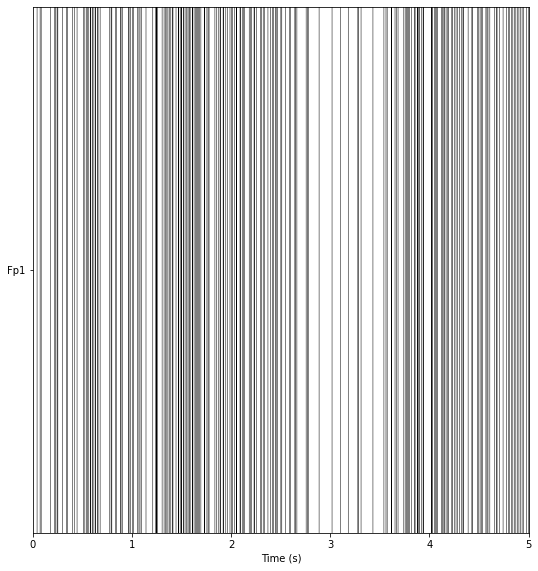

Effective window size : 16.000 (s)


/tmp/ipykernel_9687/523974043.py:5: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  simulated_raw.plot_psd(fmax=50)


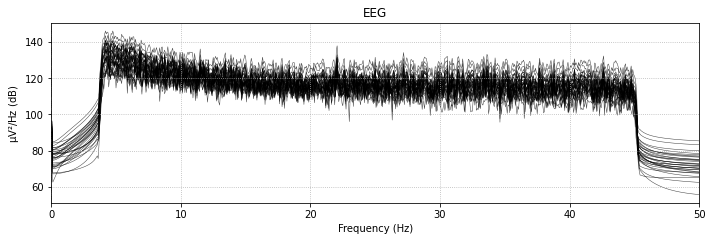

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF3, F3, F7, FC5, FC1, C3, T7, CP5, CP1, P3, P7, PO3, O1, ...
 chs: 32 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 128.0 Hz
>
[array([-3.63050377e-06-1.77888337e-20j,  3.00928212e-05+3.68530772e-20j,
       -2.03930934e-04-2.24769029e-19j,  1.12986746e-03+1.10695085e-18j,
       -5.11795050e-03-4.38737719e-18j,  1.89534752e-02+1.39267876e-17j,
       -5.73859811e-02-3.51387790e-17j,  1.42051871e-01+6.95853478e-17j,
       -2.87483085e-01-1.05619572e-16j,  4.75665687e-01+1.16504492e-16j,
       -6.43451090e-01-7.88000317e-17j,  7.11628685e-01+0.00000000e+00j,
       -6.43451090e-01+7.88000317e-17j,  4.75665687e-01-1.16504492e-16j,
       -2.87483085e-01+1.05619572e-16j,  1.42051871e-01-6.95853478e-17j,
       -5.73859811e-02+3.51387790e-17j,  1.89534752e-02-1.39267876e-17j,
       -5.11795050e-03+4.38737719e-18j,  1.12986746e-03-1.10695085e-18j,
       -2.039

In [441]:
channelData = [ decodedbson["trial"]['0']["channels"][index]["data"] for index in range(n_channels)]
#simulated_raw.info['lowpass'] = 4
simulated_raw = mne.io.RawArray(channelData, info)
simulated_raw.plot(duration=5, n_channels=1, show_scrollbars=False, show_scalebars=False)
simulated_raw.plot_psd(fmax=50)

#print(simulated_raw.more
#print(channelData[0])

#simulated_epochs = mne.EpochsArray(channelData, info)
#simulated_epochs.plot(show_scrollbars=False)
print(info)

print(morlet(sampling_freq, [sampling_freq/2], n_cycles=7))

In [471]:
iter_freqs = [
    ('delta', 1, 3),
    ('Theta', 4, 7),
    ('Alpha', 8, 12),
    ('Beta', 13, 25),
    ('Gamma', 30, 45)
]

event_id, tmin, tmax = 1, 0., 60.
events = mne.find_events(simulated_raw, stim_channel='Fp1', shortest_event=1)
frequency_map = list()

for band, fmin, fmax in iter_freqs:
    print (band, fmin, fmax)
    simulated_raw = mne.io.RawArray(channelData, info)
    simulated_raw.filter(fmin,fmax)
    
    epochs = mne.Epochs(simulated_raw, events, event_id, tmin, tmax, baseline=None,
                        preload=True)
    
    epochs.subtract_evoked()

    # get analytic signal (envelope)
    simulated_raw.apply_hilbert(envelope=True) # originally true # epochs here
    frequency_map.append(((band, fmin, fmax), simulated_raw)) # epochs here
    del epochs
    

Trigger channel has a non-zero initial value of 17 (consider using initial_event=True to detect this event)
3564 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 33 34 35 36 37 38 41 49]
delta 1 3
Creating RawArray with float64 data, n_channels=32, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 3 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 3.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Filter length: 423 samples (3.305 sec)

Not setting metadata
Not setting metadata
245 matchin

/tmp/ipykernel_9687/2557160389.py:10: RuntimeWarning: Trigger channel contains negative values, using absolute value. If data were acquired on a Neuromag system with STI016 active, consider using uint_cast=True to work around an acquisition bug
  events = mne.find_events(simulated_raw, stim_channel='Fp1', shortest_event=1)


Not setting metadata
Not setting metadata
245 matching events found
No baseline correction applied
0 projection items activated
Loading data for 245 events and 7681 original time points ...
239 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Alpha 8 12
Creating RawArray with float64 data, n_channels=32, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 213 samples (1.664 sec)

Not setting metadata
Not setting metadata
245 mat

[(('delta', 1, 3), <RawArray | 32 x 8064 (63.0 s), ~2.0 MB, data loaded>), (('Theta', 4, 7), <RawArray | 32 x 8064 (63.0 s), ~2.0 MB, data loaded>), (('Alpha', 8, 12), <RawArray | 32 x 8064 (63.0 s), ~2.0 MB, data loaded>), (('Beta', 13, 25), <RawArray | 32 x 8064 (63.0 s), ~2.0 MB, data loaded>), (('Gamma', 30, 45), <RawArray | 32 x 8064 (63.0 s), ~2.0 MB, data loaded>)]
(32, 8064)
No baseline correction applied
No baseline correction applied
No baseline correction applied
(32, 8064)
No baseline correction applied
No baseline correction applied
No baseline correction applied
(32, 8064)
No baseline correction applied
No baseline correction applied
No baseline correction applied
(32, 8064)
No baseline correction applied
No baseline correction applied
No baseline correction applied
(32, 8064)
No baseline correction applied
No baseline correction applied
No baseline correction applied


Text(0.5, 0, 'Time [ms]')

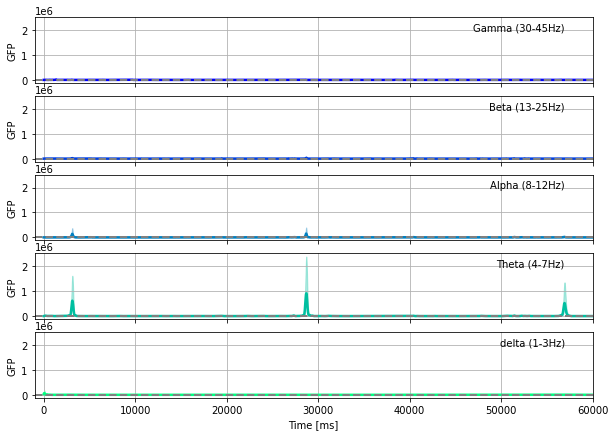

In [483]:
def stat_fun(x):
    """Return sum of squares."""
    return np.sum(x ** 2, axis=0)


# Plot
print(frequency_map)
fig, axes = plt.subplots(5, 1, figsize=(10, 7), sharex=True, sharey=True)
colors = plt.get_cmap('winter_r')(np.linspace(0, 1, 5))
for ((freq_name, fmin, fmax), average), color, ax in zip(
        frequency_map, colors, axes.ravel()[::-1]):
    times = average.times * 1e3
    print(average.get_data().shape)
    gfp = np.sum(average.get_data() ** 2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=None)
    ax.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    ax.axhline(0, linestyle='--', color='grey', linewidth=2)
    ci_low, ci_up = bootstrap_confidence_interval(average.get_data(), random_state=0,
                                                  stat_fun=stat_fun)
    ci_low = rescale(ci_low, average.times, baseline=None)
    ci_up = rescale(ci_up, average.times, baseline=None)
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel('GFP')
    ax.annotate('%s (%d-%dHz)' % (freq_name, fmin, fmax),
                xy=(0.95, 0.8),
                horizontalalignment='right',
                xycoords='axes fraction')
    ax.set_xlim(-1000, 60000)

axes.ravel()[-1].set_xlabel('Time [ms]')

In [417]:
from ssqueezepy import ssq_cwt, ssq_stft, cwt, icwt
from ssqueezepy.visuals import plot, imshow
from ssqueezepy.wavelets import Wavelet, center_frequency
from ssqueezepy.experimental import scale_to_freq,freq_to_scale

In [484]:
#    ('delta', 1, 3),
#    ('Theta', 4, 7),
#    ('Alpha', 8, 12),
#    ('Beta', 13, 25),
#    ('Gamma', 30, 45)
def getScaleForFrequency(wavelet=Wavelet('morlet'),fromFreq=1,toFreq=3, fs=128.0):
    #print([fromFreq/fs,toFreq/fs])
    output = freq_to_scale(np.array([fromFreq,toFreq]),wavelet,wavelet.N,fs=fs, n_search_scales=100)
    output = output[::-1]
    scale = (output[1] - output[0]) / 100.0
    output = np.arange(output[0],output[1],scale)
    return output


def extractSignal(signal, wavelet, scales, fs=128.0):
    coefficients,scales = cwt(signal,wavelet=wavelet,scales=scales,fs=fs)
    newSignal = icwt(coefficients,scales=scales)
    return newSignal, coefficients, scales

def extractBands(signal, wavelet=Wavelet('morlet'), fs=128.0):
    deltaScales = getScaleForFrequency(fromFreq=1,toFreq=3,wavelet=wavelet,fs=fs)
    deltaSignal, coefficients, scales = extractSignal(signal, wavelet, deltaScales, fs=fs)
    print(coefficients.shape)
    print(coefficients[0])
    gfp = np.sum(np.abs(coefficients) ** 2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=None)
    plt.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    plt.show()
    #imshow(coefficients, abs=1, yticks=scale_to_freq(scales, wavelet, wavelet.N, fs=fs), cmap='turbo', show=1)
    
    thetaScales = getScaleForFrequency(fromFreq=4,toFreq=7,wavelet=wavelet,fs=fs)
    thetaSignal, coefficients, scales = extractSignal(signal, wavelet, thetaScales, fs=fs)
    gfp = np.sum(np.abs(coefficients) ** 2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=None)
    plt.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    plt.show()
    #imshow(coefficients, abs=1, yticks=scale_to_freq(scales, wavelet, wavelet.N, fs=fs), cmap='turbo', show=1)
    
    alphaScales = getScaleForFrequency(fromFreq=8,toFreq=12,wavelet=wavelet,fs=fs)
    alphaSignal, coefficients, scales = extractSignal(signal, wavelet, alphaScales, fs=fs)
    #imshow(coefficients, abs=1, yticks=scale_to_freq(scales, wavelet, wavelet.N, fs=fs), cmap='turbo', show=1)
    
    betaScales = getScaleForFrequency(fromFreq=13,toFreq=25,wavelet=wavelet,fs=fs)
    betaSignal, coefficients, scales = extractSignal(signal, wavelet, betaScales, fs=fs)
    #imshow(coefficients, abs=1, yticks=scale_to_freq(scales, wavelet, wavelet.N, fs=fs), cmap='turbo', show=1)
    
    gammaScales = getScaleForFrequency(fromFreq=30,toFreq=45,wavelet=wavelet,fs=fs)
    gammaSignal, coefficients, scales = extractSignal(signal, wavelet, gammaScales, fs=fs)
    #imshow(coefficients, abs=1, yticks=scale_to_freq(scales, wavelet, wavelet.N, fs=fs), cmap='turbo', show=1)
    #print(scale_to_freq(scales, wavelet, 1024, fs=fs))
    #print(scales)
    #print(getScaleForFrequency(fromFreq=30,toFreq=45,wavelet=wavelet,fs=fs))
    return deltaSignal, thetaSignal, alphaSignal, betaSignal, gammaSignal

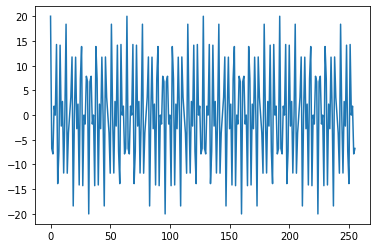

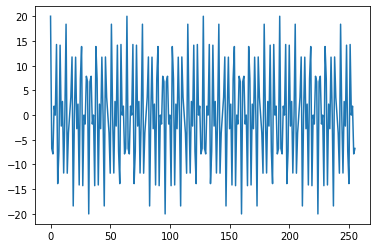

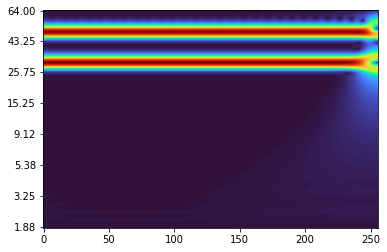

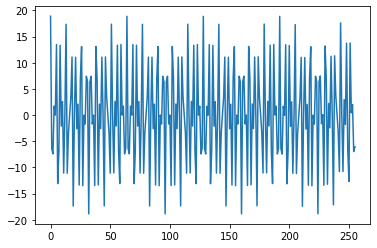

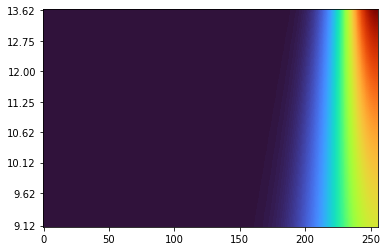

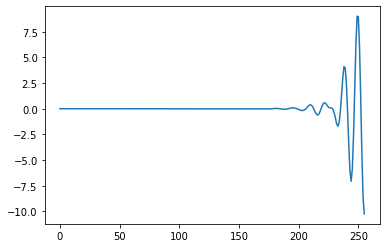

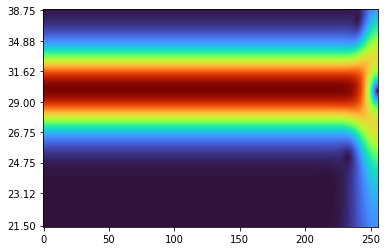

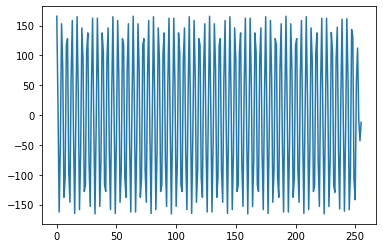

In [457]:
def viz(x, Tx=None, Wx=None):
    if type(Wx) != type(None):
        plt.imshow(np.abs(Wx), aspect='auto', cmap='turbo')
        plt.show()
    if type(Tx) != type(None):
        plt.imshow(np.abs(Tx), aspect='auto', vmin=0, vmax=.2, cmap='turbo')
        plt.show()

        
        
def viz2(x, Tx=None, yticks=None):
    if type(Tx) != type(None):
        #print(Tx.shape)
        a = np.abs(Tx).max() * .9
        imshow(Tx, abs=1,yticks=yticks,cmap='turbo', show=1)
        #plt.show()
#%%# Define signal ####################################
N = 128
t = np.arange(0,2,1/N)
#print(t)
x = xo =  np.cos(2*np.pi * 50 * t) * 10 + np.cos(2*np.pi * 30 * t) * 10
#xo += xo[::-1]  # add self reflected
#x = xo + np.sqrt(2) * np.random.randn(N)  # add noise

plt.plot(xo); plt.show()
plt.plot(x);  plt.show()

wavelet = Wavelet('morlet')

#scalar = center_frequency(wavelet,1.01,kind='peak')*N 

#print(scalar/scales)
#print(wavelet.xifn(1)*N)

coefficients,scales = cwt(x,wavelet=wavelet,t=t,scales='log')

scala = scale_to_freq(scales,wavelet, 1024, fs=N, padtype='None')

viz2(x,coefficients,scala)

#coefficients = coefficients[100:200,:]
#scales = scales[100:200]
y0 = icwt(coefficients,scales=scales)

plt.plot(y0); plt.show()

#print(scales)




coefficients,scales = cwt(x,wavelet=wavelet,scales=np.arange(20,30,.1),t=t)
#print(center_frequency(wavelet,1.1,kind='energy'))


viz2(xo,coefficients,scale_to_freq(scales,wavelet, 1024, fs=N))

coefficients = coefficients[2:,:]
scales = scales[2:]





y1 = icwt(coefficients,scales=scales)
#print(y1)
plt.plot(y1); plt.show()


scales = getScaleForFrequency(fromFreq=25,toFreq=35,wavelet=wavelet,fs=N)
coefficients,scales = cwt(x,wavelet=wavelet,scales=scales,t=t)

viz2(xo,coefficients,scale_to_freq(scales,wavelet, 1024, fs=N))

y1 = icwt(coefficients,scales=scales)
#print(y1)
plt.plot(y1); plt.show()


#help(cwt)

(100, 8064)
[-0.10217317-4.4703484e-08j -0.1008353 -1.6443059e-02j
 -0.0968574 -3.2451592e-02j ... -0.60360616+1.8993749e-01j
 -0.6255701 +9.6101657e-02j -0.63295007+1.1175871e-08j]
No baseline correction applied


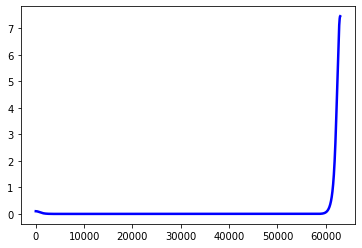

No baseline correction applied


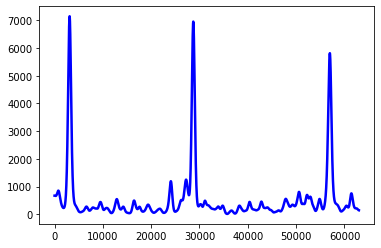

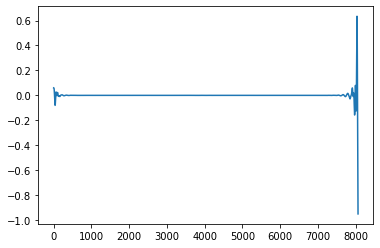

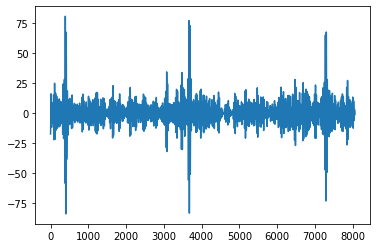

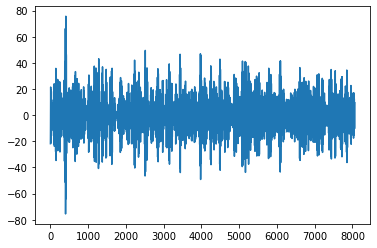

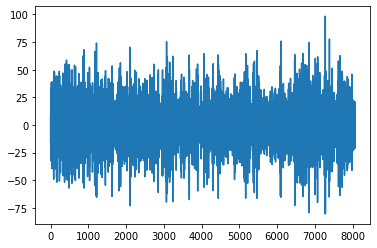

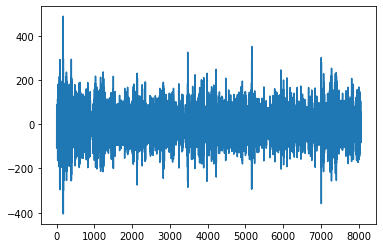

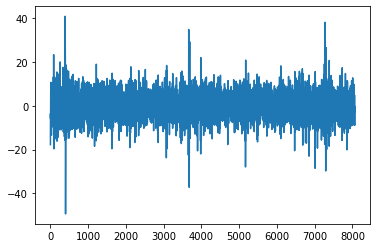

In [485]:


deltaSignal, thetaSignal, alphaSignal, betaSignal, gammaSignal = extractBands(np.array(channelData[0]), fs=128)

plt.plot(deltaSignal); plt.show()
plt.plot(thetaSignal); plt.show()
plt.plot(alphaSignal); plt.show()
plt.plot(betaSignal); plt.show()
plt.plot(gammaSignal); plt.show()
plt.plot(np.array(channelData[0])); plt.show()

    

(245, 2560) (245, 2560)


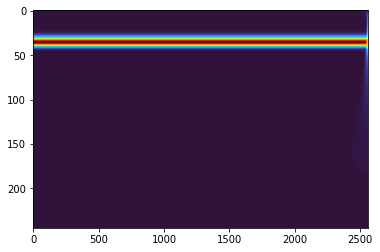

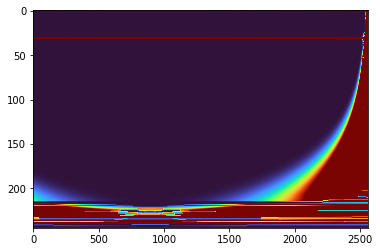

In [211]:
#%%# CWT + SSQ CWT ####################################
Twxo, Wxo, *_ = ssq_cwt(xo,fs=128.0)
print(Twxo.shape,Wxo.shape)
viz(xo, Twxo, Wxo)

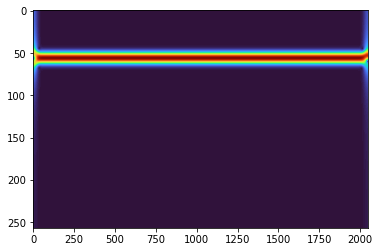

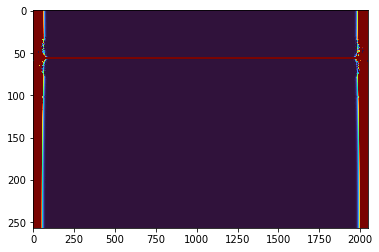

In [318]:
Tsx, Sx, *_ = ssq_stft(x,fs=N)
viz(x, np.flipud(Tsx), np.flipud(Sx))

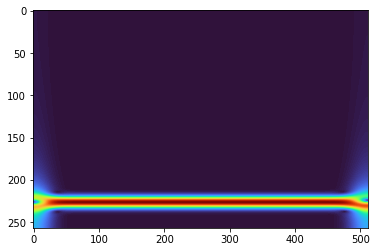

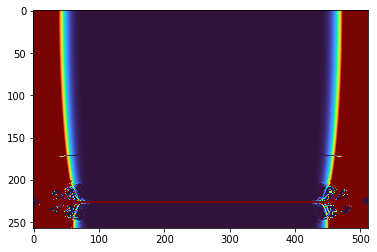

In [261]:
#%%# STFT + SSQ STFT ##################################
Tsxo, Sxo, *_ = ssq_stft(xo,fs=N)
viz(xo, np.flipud(Tsxo), np.flipud(Sxo))

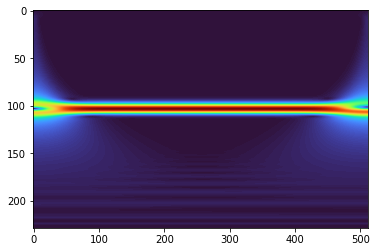

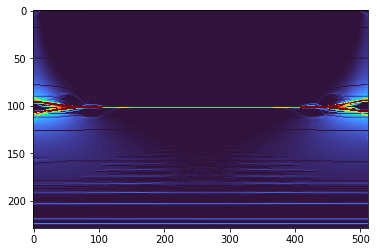

In [260]:
Twx, Wx, *_ = ssq_cwt(x,fs=N)
viz(x, Twx, Wx)

vis


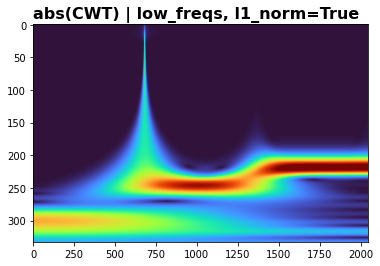

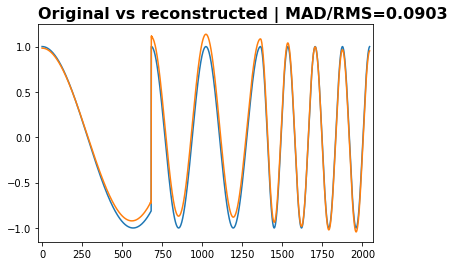

vis


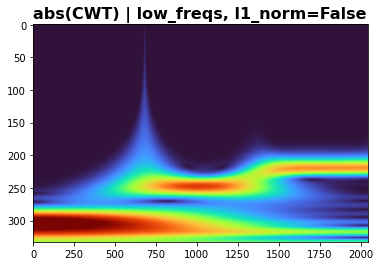

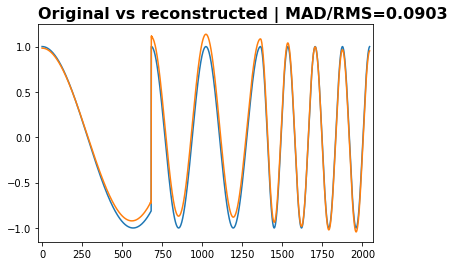

vis


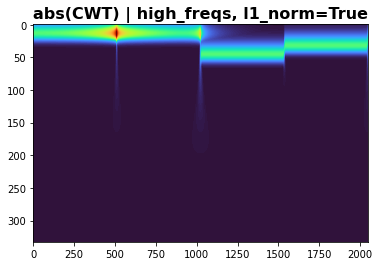

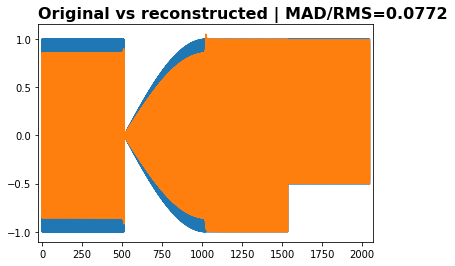

vis


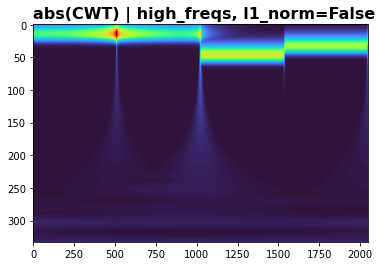

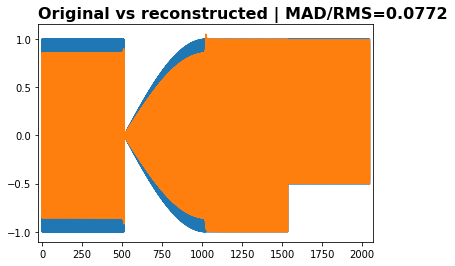


cwt PASSED
errs: 0.09035, 0.09035, 0.07717, 0.07717


In [259]:
# -*- coding: utf-8 -*-
import os
#import pytest
import numpy as np
from ssqueezepy import ssq_cwt, issq_cwt, ssq_stft, issq_stft
from ssqueezepy import cwt, icwt, stft, istft
from ssqueezepy._stft import get_window
from ssqueezepy.toolkit import lin_band


VIZ = 0  # set to 1 to enable various visuals and run without pytest
os.environ['SSQ_GPU'] = '0'  # in case concurrent tests set it to '1'


#### Helper methods ##########################################################
def _t(min, max, N):
    return np.linspace(min, max, N, endpoint=False)

def cos_f(freqs, N=128, phi=0):
    return np.concatenate([np.cos(2 * np.pi * f * (_t(i, i + 1, N) + phi))
                           for i, f in enumerate(freqs)])

def mad_rms(x, xrec):
    """Reconstruction error metric; scale-invariant, robust to outliers
    and partly sparsity. https://stats.stackexchange.com/q/495242/239063"""
    return np.mean(np.abs(x - xrec)) / np.sqrt(np.mean(x**2))

#### Test signals ############################################################
def echirp(N):
    t = _t(0, 10, N)
    return np.cos(2 * np.pi * 3 * np.exp(t / 3)), t

def lchirp(N):
    t = _t(0, 10, N)
    return np.cos(np.pi * t**2), t


def _freqs(N, freqs):
    x = cos_f(freqs, N // len(freqs))
    ts = _t(0, len(x) / N, len(x))
    return x, ts

def fast_transitions(N):
    return _freqs(N, np.array([N/100, N/200, N/3, N/20,
                               N/3-1, N/50, N/4, N/150]) / 8)

def low_freqs(N):
    return _freqs(N, [.3, .3, 1, 1, 2, 2])

def high_freqs(N):
    return _freqs(N, np.array([N/2, N/2-1, N/4, N/3]) / 4)


#### Tests ###################################################################
test_fns = (low_freqs, high_freqs)
wavelet = ('gmw', {'beta': 8, 'dtype': 'float64'})
th = .1


def test_ssq_cwt():
    errs = []
    for fn in test_fns:
        x, ts = fn(2048)
        for scales in ('log', 'log-piecewise', 'linear'):
            if fn.__name__ == 'low_freqs':
                if scales == 'linear':
                    # 'linear' default can't handle low frequencies for large N
                    # 'log-piecewise' maps it too sparsely
                    continue
                else:
                    scales = f'{scales}:maximal'

            Tx, *_ = ssq_cwt(x, wavelet, scales=scales, nv=32, t=ts)
            xrec = issq_cwt(Tx, wavelet)

            errs.append(round(mad_rms(x, xrec), 5))
            title = "abs(SSQ_CWT) | {}, scales='{}'".format(fn.__qualname__,
                                                            scales)
            _maybe_viz(Tx, x, xrec, title, errs[-1])
            assert errs[-1] < th, (errs[-1], fn.__name__, scales)
    print("\nssq_cwt PASSED\nerrs:", ', '.join(map(str, errs)))


def test_cwt():
    errs = []
    for fn in test_fns:
        x, ts = fn(2048)
        for l1_norm in (True, False):
            scales = ('log:maximal' if fn.__name__ in ('low_freqs', 'high_freqs')
                      else 'log')
            # 'linear' default can't handle low frequencies for large N
            kw = dict(wavelet=wavelet, scales=scales, l1_norm=l1_norm, nv=32)

            Wx, *_ = cwt(x, t=ts, **kw)
            xrec = icwt(Wx, one_int=True, **kw)

            errs.append(round(mad_rms(x, xrec), 5))
            title = f"abs(CWT) | l1_norm={l1_norm}"
            title = "abs(CWT) | {}, l1_norm={}".format(fn.__qualname__,
                                                       l1_norm)
            print('vis')
            _maybe_viz(Wx, x, xrec, title, errs[-1])
            assert errs[-1] < th, (errs[-1], fn.__name__, f"l1_norm: {l1_norm}")
    print("\ncwt PASSED\nerrs:", ', '.join(map(str, errs)))


def test_cwt_log_piecewise():
    x, ts = echirp(1024)

    wavelet = 'gmw'
    Tx, Wx, ssq_freqs, scales, *_ = ssq_cwt(x, wavelet, scales='log-piecewise',
                                            t=ts, preserve_transform=True)
    xrec_ssq_cwt = issq_cwt(Tx, 'gmw')
    xrec_cwt = icwt(Wx, wavelet, scales=scales)

    err_ssq_cwt = round(mad_rms(x, xrec_ssq_cwt), 5)
    err_cwt = round(mad_rms(x, xrec_cwt), 5)
    assert err_ssq_cwt < .02, err_ssq_cwt
    assert err_cwt < .02, err_cwt


def test_component_inversion():
    def echirp(N):
        t = np.linspace(0, 10, N, False)
        return np.cos(2 * np.pi * np.exp(t / 3)), t

    N = 2048
    noise_var = 6

    x, ts = echirp(N)
    x *= (1 + .3 * cos_f([1], N))  # amplitude modulation
    xo = x.copy()
    np.random.seed(4)
    x += np.sqrt(noise_var) * np.random.randn(len(x))

    wavelet = ('gmw', {'beta': 6})
    Tx, *_ = ssq_cwt(x, wavelet, scales='log:maximal', nv=32, t=ts, flipud=0)

    # hand-coded, subject to failure
    bw, slope, offset = .035, .44, .45
    Cs, freqband = lin_band(Tx, slope, offset, bw, norm=(0, 2e-1))

    xrec = issq_cwt(Tx, wavelet, Cs, freqband)[0]

    axof   = np.abs(np.fft.rfft(xo))
    axrecf = np.abs(np.fft.rfft(xrec))

    err_sig = mad_rms(xo, xrec)
    err_spc = mad_rms(axof, axrecf)
    print("signal   MAD/RMS: %.6f" % err_sig)
    print("spectrum MAD/RMS: %.6f" % err_spc)
    assert err_sig <= .40, f"{err_sig} > .40"
    assert err_spc <= .10, f"{err_spc} > .10"


def test_stft():
    """Ensure every combination of even & odd configs can be handled;
    leave window length unspecified to ensure unspecified inverts unspecified.
    """
    th = 1e-14
    for N in (128, 129):
      x = np.random.randn(N)
      for n_fft in (120, 121):
        for hop_len in (1, 2, 3):
          for modulated in (True, False):
            kw = dict(hop_len=hop_len, n_fft=n_fft, modulated=modulated)

            Sx = stft(x, dtype='float64', **kw)
            xr = istft(Sx, N=len(x), **kw)

            txt = ("\nSTFT: (N, n_fft, hop_len, modulated) = ({}, {}, "
                   "{}, {})").format(N, n_fft, hop_len, modulated)
            assert len(x) == len(xr), "%s != %s %s" % (N, len(xr), txt)
            mae = np.abs(x - xr).mean()
            assert mae < th, "MAE = %.2e > %.2e %s" % (mae, th, txt)


def test_ssq_stft():
    """Same as `test_stft` except don't test `hop_len` or `modulated` since
    only `1` and `True` are invertible (by the library, and maybe theoretically).
    `window_scaling=.5` has >x2 greater MAE for some reason. May look into.
    """
    th = 1e-1
    for N in (128, 129):
      x = np.random.randn(N)
      for n_fft in (120, 121):
        for window_scaling in (1., .5):
          if window_scaling == 1:
              window = None
          else:
              window = get_window(window, win_len=n_fft//1, n_fft=n_fft)
              window *= window_scaling

          Sx, *_ = ssq_stft(x, window=window, n_fft=n_fft)
          xr = issq_stft(  Sx, window=window, n_fft=n_fft)

          txt = ("\nSSQ_STFT: (N, n_fft, window_scaling) = ({}, {}, {})"
                 ).format(N, n_fft, window_scaling)
          assert len(x) == len(xr), "%s != %s %s" % (N, len(xr), txt)
          mae = np.abs(x - xr).mean()
          assert mae < th, "MAE = %.2e > %.2e %s" % (mae, th, txt)




def _maybe_viz(Wx, xo, xrec, title, err):
    VIZ = True
    if not VIZ:
        return
    mx = np.abs(Wx).max()
    if 'SSQ' in title:
        Wx = np.pad(np.flipud(Wx), [[5], [0]])
        mx = .1*mx
    else:
        mx = .9*mx

    imshow(Wx, abs=1, norm=(0, mx), cmap='turbo', show=1, title=title)
    plot(xo, title="Original vs reconstructed | MAD/RMS=%.4f" % err)
    plot(xrec, show=1)


if __name__ == '__main__':

    from ssqueezepy.visuals import plot, imshow
    test_cwt()